In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: BBC evaluation

**04.11.2020**

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys, glob
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
from synthetic_data.trajectory_class import get_pickle_trajectory
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays

In [7]:
from stay_classification.metrics import eval_synth_data
from stay_classification.metrics import get_segments_scores, get_segments_errs
from stay_classification.metrics import get_pred_labels, get_labels_from_clusters

In [8]:
from synthetic_data.trajectory import get_stay_indices, get_adjusted_stays

get_err = lambda trues, preds: np.sum(abs(trues-preds))/trues.size

In [9]:
from stay_classification.merge_tools import merge_clusters_gen
from stay_classification.bounding_box_classifier.bounding_box_classifier import stay_classifier_testing

# Batch data evaluation

In [10]:
dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [11]:
time_thresh = 1/6
dist_thresh=0.25

In [12]:
data_dir = os.path.abspath('../../')+f"/classifiers_playground/metric_box_classifier/testdata_training_set__canonical_3stays/"
os.path.isdir(data_dir)
pkls = glob.glob(data_dir + "*.pkl")

## Load, Classify, Measure

In [13]:
# For the correct nr of stays
correct = []
precs3, a_precs3, w_precs3 = [], [], []
recs3, a_recs3, w_recs3 = [], [], []
errs3, a_errs3, w_errs3 = [], [], []

# For the incorrect nr of stays
incorrect = []
precs, a_precs, w_precs = [], [], []
recs, a_recs, w_recs = [], [], []
errs, a_errs, w_errs = [], [], []


bad_list = []

precrec_limit = 0.80

ii = 0

length_criterion_break = False
iqr_trim = False
verbose = False

total = 1000
start = 0#1000

for ii in range(start, total):
    
    # Load the data    
    t_arr, r_arr, x_arr, segments = get_pickle_trajectory(pkls[ii])
    t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

    # Get the true event indices (needed for the total error)
    true_indices = get_stay_indices(get_adjusted_stays(segments, t_arr), t_arr)
    true_labels = np.zeros(t_arr.shape)
    for pair in true_indices:
        true_labels[pair[0]:pair[1]+1] = 1
    
    # Get the stay clusters
    all_cluters = stay_classifier_testing(t_arr, x_arr, time_thresh, dist_thresh, verbose)  
    
    # Make some measurements
    final_len=len(all_cluters[-1])
    # total scores
    prec, rec, conmat = eval_synth_data(t_arr, segments, all_cluters[-1])
    # seg. scores
    _, a_prec, w_prec, _, a_rec, w_rec = get_segments_scores(t_arr, segments, all_cluters[-1])   
    
    # Total error
    pred_labels = get_pred_labels(all_cluters[-1], t_arr.shape)
    err = get_err(true_labels,pred_labels)
    # Segment errors
    _, a_err, w_err = get_segments_errs(t_arr, segments, all_cluters[-1])
    
    # Get the expected number of stays (in general)
    stays_tag = int((x_segs.size)/3)
    # Get the true event indices (needed for the total error)
    true_clusts = [list(range(pair[0],pair[1]+1)) for pair in true_indices if abs(t_arr[pair[0]]-t_arr[pair[1]]) > time_thresh]  
    true_clusts = merge_clusters_gen(t_arr, x_arr, true_clusts, time_thresh, dist_thresh)
    stays_tag = len(true_clusts)
    stays_tag = int((x_segs.size)/3)
    
    #len_all_clusts = len(clusters)
    if final_len != stays_tag:
        #print(f"{prec:6.3f}, {rec:6.3f}, {final_len:3d}, trajectory{path_to_file.split('/trajectory')[1]}")        
        incorrect.append(final_len)
        precs.append(prec)
        a_precs.append(a_prec)
        w_precs.append(w_prec)
        recs.append(rec)        
        a_recs.append(a_rec)        
        w_recs.append(w_rec)
        errs.append(err)        
        a_errs.append(a_err)        
        w_errs.append(w_err)                
    else:
        correct.append(final_len)
        precs3.append(prec)
        a_precs3.append(a_prec)
        w_precs3.append(w_prec)
        recs3.append(rec)        
        a_recs3.append(a_rec)        
        w_recs3.append(w_rec)        
        errs3.append(err)        
        a_errs3.append(a_err)
        w_errs3.append(w_err)
    
    # progress output
    if ((ii-start)>0) & (ii % int(0.1*total) == 0):
        print(f"{ii:4d} of {total:5d}",
              f"correct stays, {(len(correct)/(ii-start+1)):6.3f};",
              f"incorrect stays, {(len(incorrect)/(ii-start+1)):6.3f}")
        


correct_frac = (len(correct)/(total-start))
incorrect_frac = (len(incorrect)/(total-start))

print(f"Tot. scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}")

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 100 of  1000 correct stays,  0.911; incorrect stays,  0.089
 200 of  1000 correct stays,  0.950; incorrect stays,  0.050
 300 of  1000 correct stays,  0.953; incorrect stays,  0.047
 400 of  1000 correct stays,  0.945; incorrect stays,  0.055
 500 of  1000 correct stays,  0.936; incorrect stays,  0.064
 600 of  1000 correct stays,  0.938; incorrect stays,  0.062
 700 of  1000 correct stays,  0.942; incorrect stays,  0.058
 800 of  1000 correct stays,  0.940; incorrect stays,  0.060
 900 of  1000 correct stays,  0.940; incorrect stays,  0.060
Tot. scores: correct stays,  0.939; incorrect stays,  0.061


### 1000 trajectories, 3-stays
```
100 of  1000 correct stays,  0.911; incorrect stays,  0.089
 200 of  1000 correct stays,  0.950; incorrect stays,  0.050
 300 of  1000 correct stays,  0.953; incorrect stays,  0.047
 400 of  1000 correct stays,  0.945; incorrect stays,  0.055
 500 of  1000 correct stays,  0.934; incorrect stays,  0.066
 600 of  1000 correct stays,  0.937; incorrect stays,  0.063
 700 of  1000 correct stays,  0.939; incorrect stays,  0.061
 800 of  1000 correct stays,  0.938; incorrect stays,  0.062
 900 of  1000 correct stays,  0.937; incorrect stays,  0.063
Tot. scores: correct stays,  0.936; incorrect stays,  0.064
```

## Visualizations

In [14]:
from stay_classification.metrics_plotting import plot_scores_stats, plot_errs_stats, plot_scores_stats_cominbed

In [15]:
data_plot_dir = os.path.abspath('./') + "/visualizations/metrics_v2_optimal/"
if os.path.isdir(data_plot_dir) == False:
    os.mkdir(data_plot_dir)

### Prec/rec score distributions

#### Total scores

In [16]:
nr_stays = 3

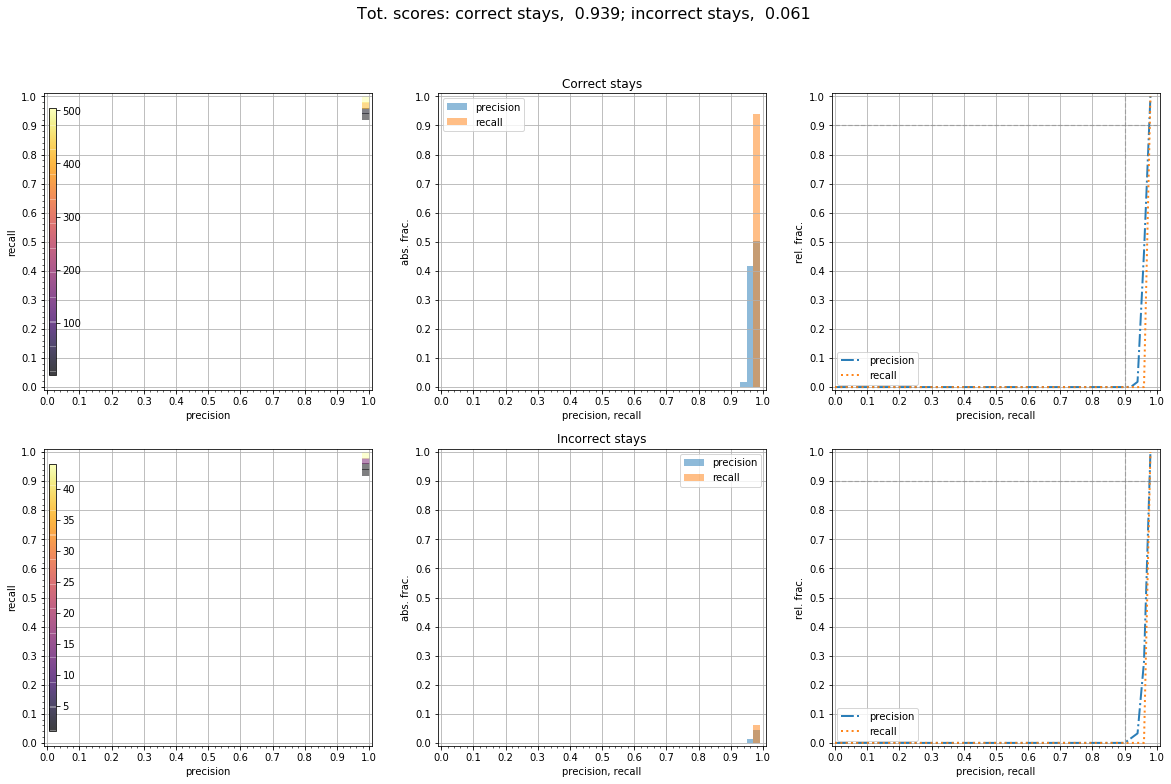

In [17]:
title = f"Tot. scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, axs = plot_scores_stats(precs3, recs3, precs, recs, title)

fig.savefig(data_plot_dir + f"metrics__{nr_stays}stays.png")

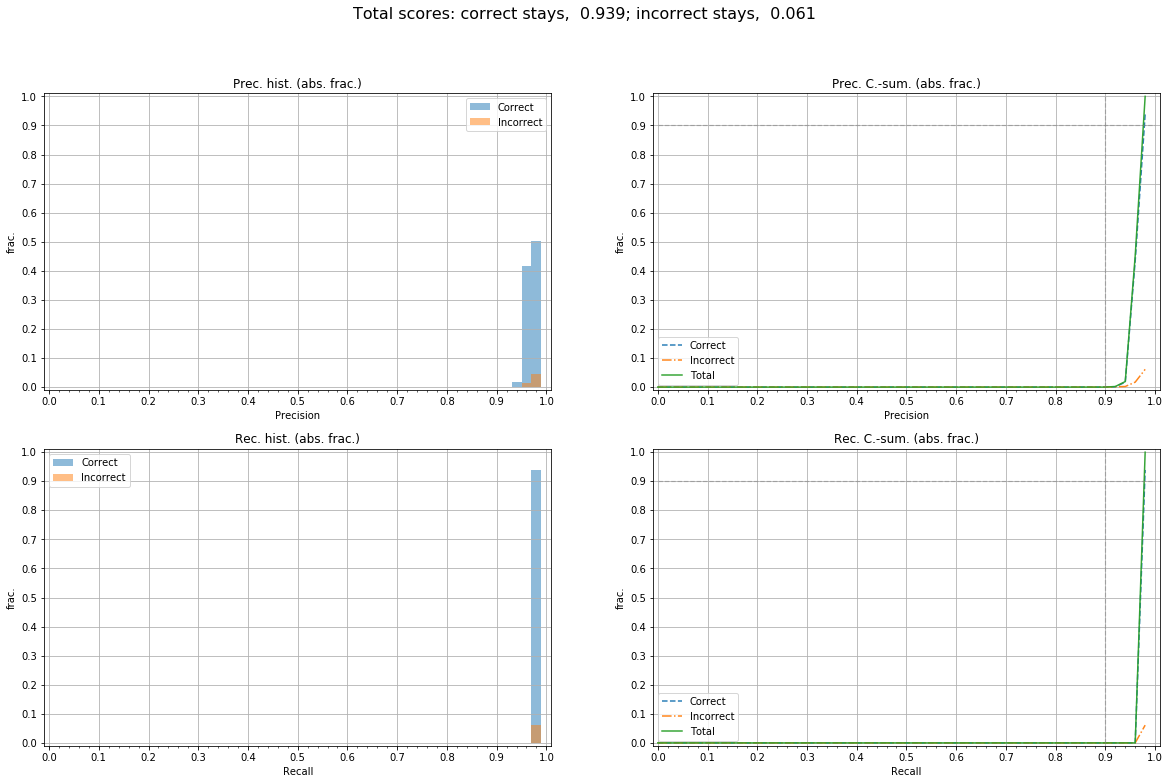

In [18]:
title = f"Total scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, axs = plot_scores_stats_cominbed(precs3, recs3, precs, recs, title)

fig.savefig(data_plot_dir + f"metrics__{nr_stays}stays_seg_scores_combined_tot.png")

#### Segment-averaged score distributions

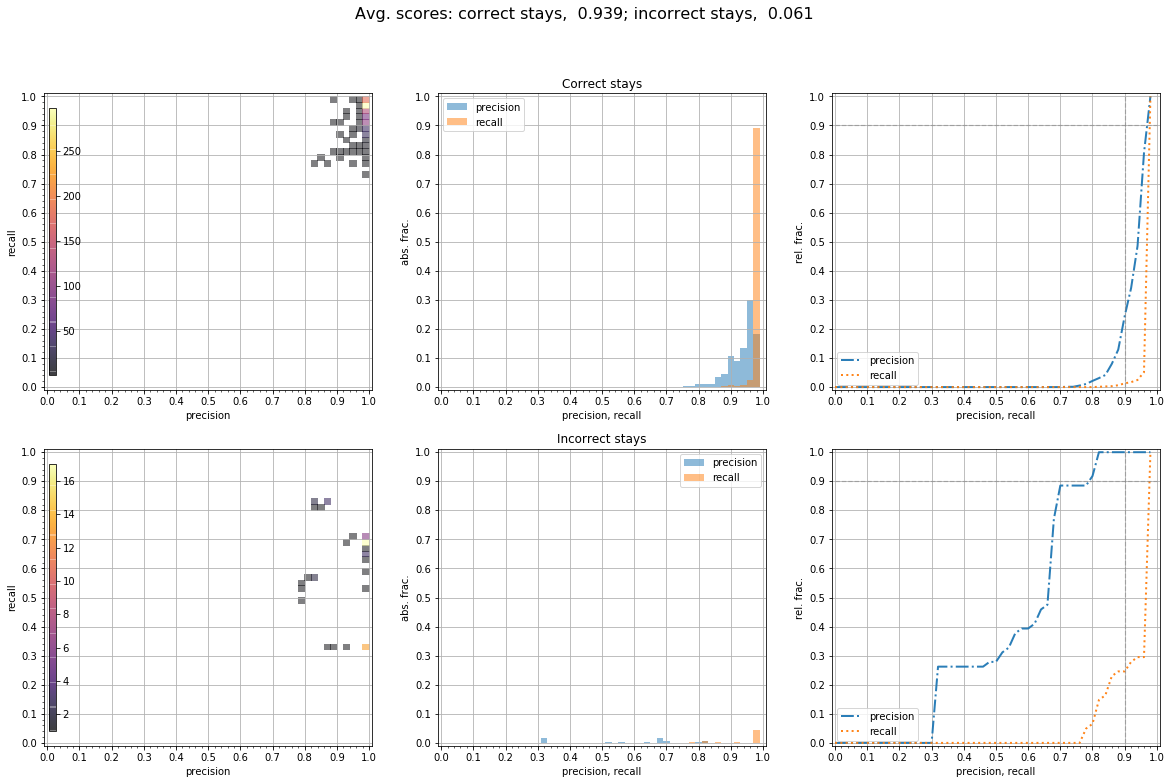

In [19]:
title = f"Avg. scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, axs = plot_scores_stats(a_precs3, a_recs3, a_precs, a_recs, title)

fig.savefig(data_plot_dir + f"metrics__{nr_stays}stays_seg_scores_avg.png")

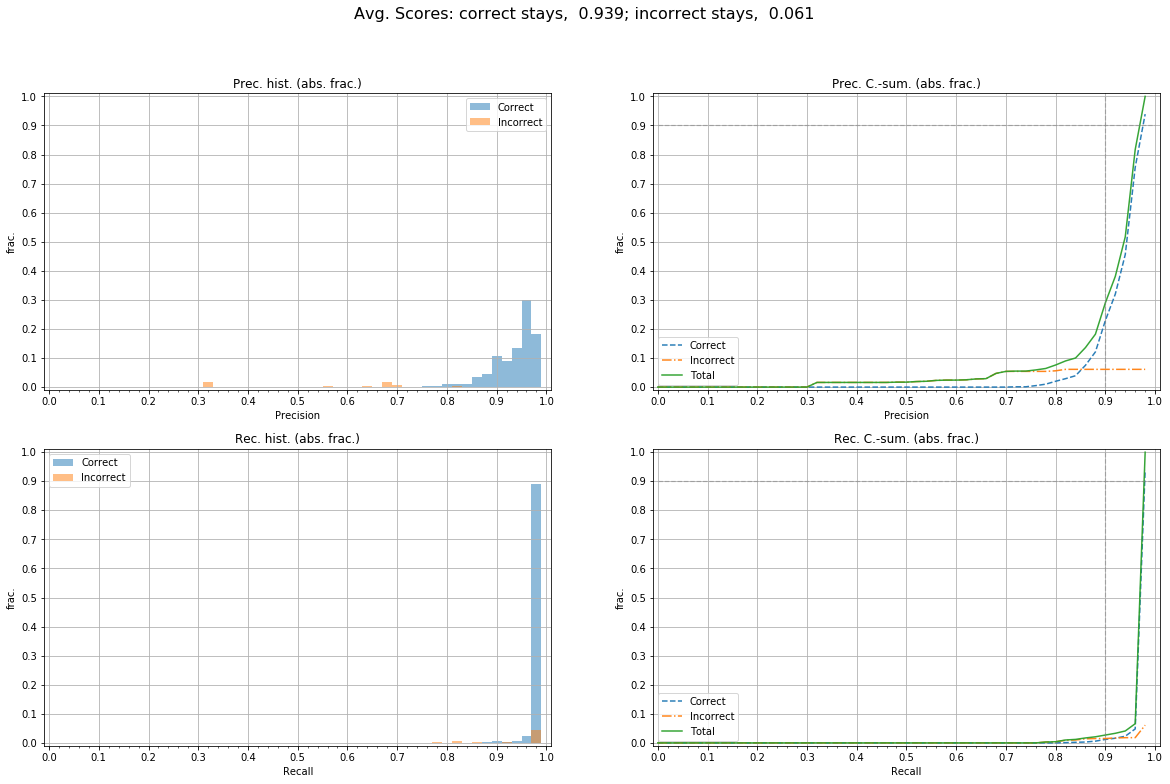

In [20]:
title = f"Avg. Scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, axs = plot_scores_stats_cominbed(a_precs3, a_recs3, a_precs, a_recs, title)

fig.savefig(data_plot_dir + f"metrics__{nr_stays}stays_seg_scores_combined_avg.png")

#### Segment, weighted-averaged score distributions

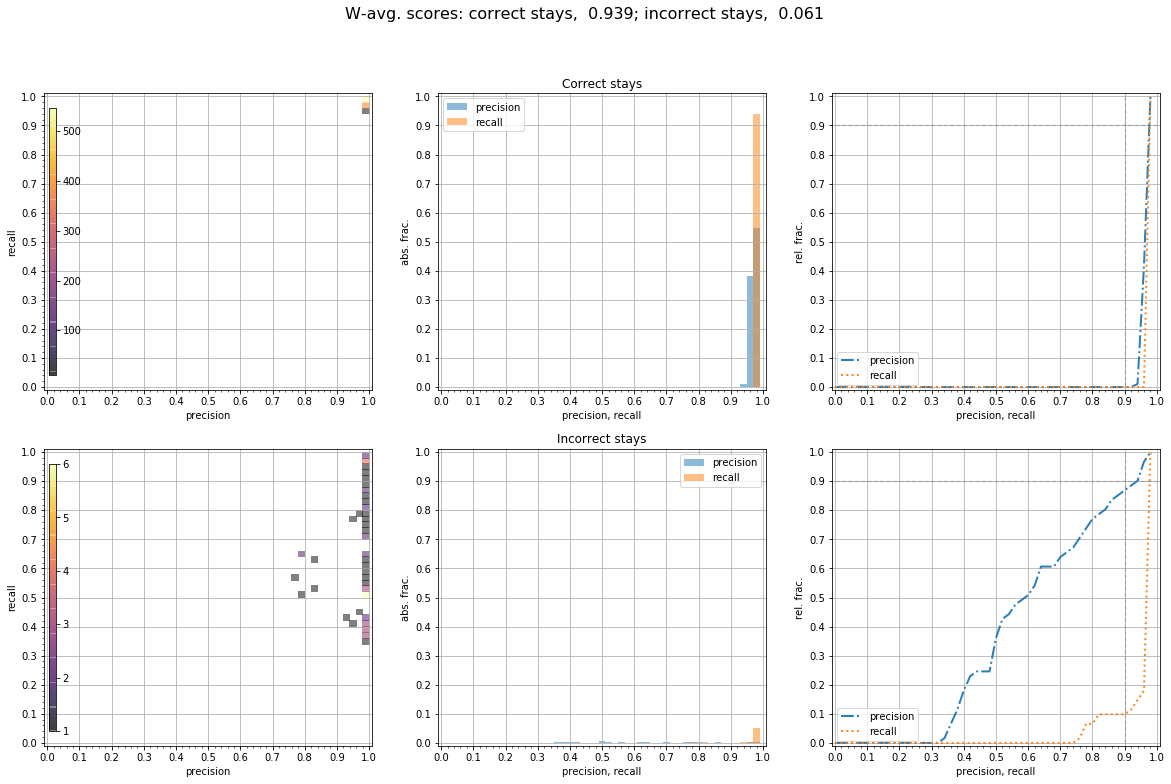

In [21]:
title = f"W-avg. scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, axs = plot_scores_stats(w_precs3, w_recs3, w_precs, w_recs, title)

fig.savefig(data_plot_dir + f"metrics__{nr_stays}stays_seg_scores_wavg.png")

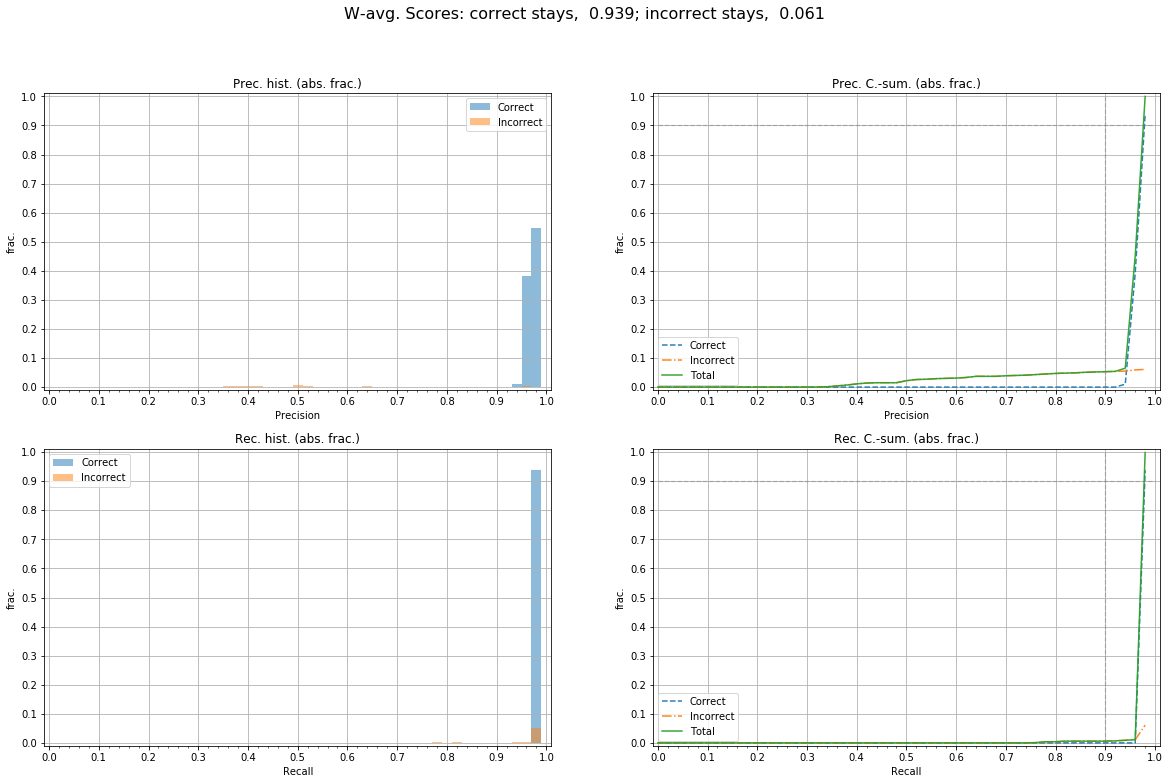

In [22]:
title = f"W-avg. Scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, axs = plot_scores_stats_cominbed(w_precs3, w_recs3, w_precs, w_recs, title)

fig.savefig(data_plot_dir + f"metrics__{nr_stays}stays_seg_scores_combined_wavg.png")

### Error stats

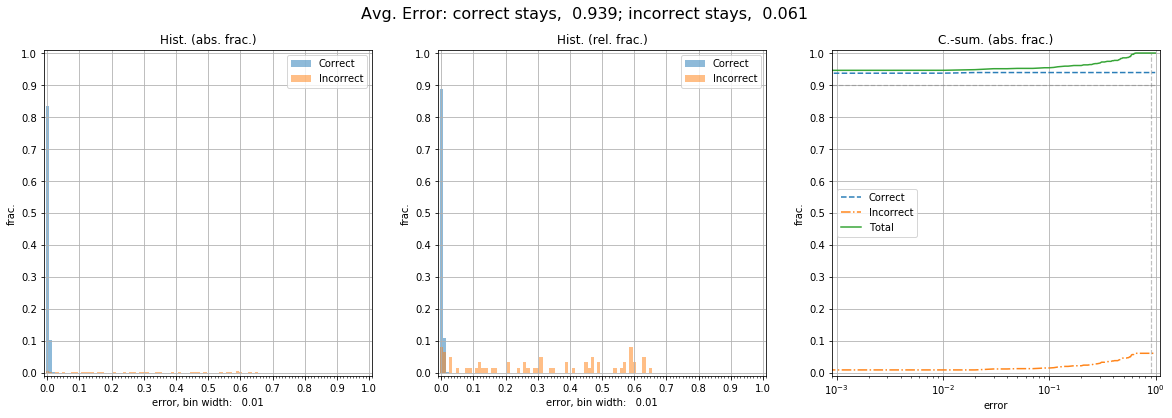

In [23]:
title = f"Avg. Error: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, ax = plot_errs_stats(w_errs3, w_errs, title)

fig.savefig(data_plot_dir + f"metrics__{nr_stays}stays_seg_errs_avg.png")

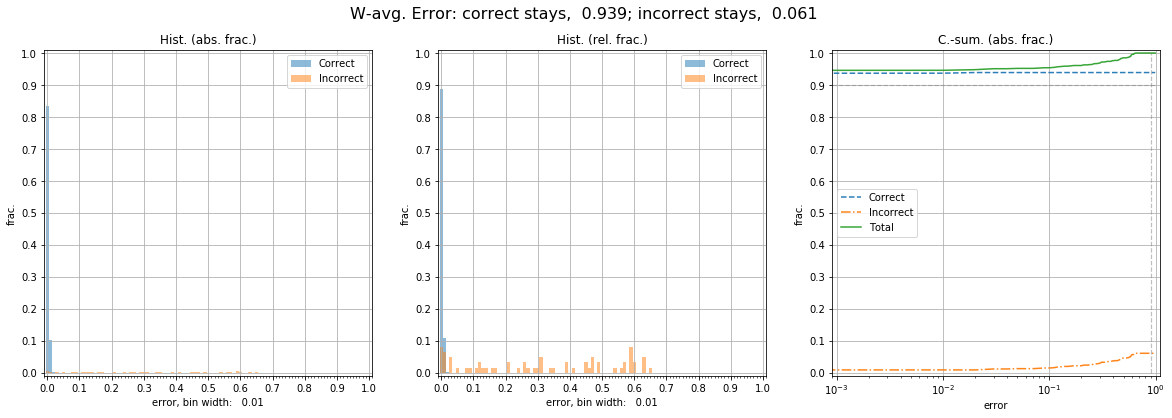

In [24]:
title = f"W-avg. Error: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, ax = plot_errs_stats(w_errs3, w_errs, title)

fig.savefig(data_plot_dir + f"metrics__{nr_stays}stays_seg_errs_wavg.png")

---